In [383]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Process data

In [3]:
df = pd.read_csv("grants.csv")
details = pd.read_csv("grant_opportunity_details.csv")

C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_50156\3547180560.py:1: DtypeWarning: Columns (6,8,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("grants.csv")


In [4]:
df["posted_date"] = pd.to_datetime(df["posted_date"])

In [333]:
# top agencies by number of grant programmes
top = df["agency_name"].value_counts().to_frame().reset_index()

# top 12
df["agency_top12"] = "Other"
df.loc[df["agency_name"].isin(top.head(12)["agency_name"].to_list()), "agency_top12"] = df["agency_name"]

# top 15
df["agency_top15"] = "Other"
df.loc[df["agency_name"].isin(top.head(15)["agency_name"].to_list()), "agency_top15"] = df["agency_name"]

top.head(15)

,agency_name,count
0,National Institutes of Health,11239
1,National Park Service,8426
2,Fish and Wildlife Service,4122
3,Bureau of Land Management,2868
4,Geological Survey,2311
5,Centers for Disease Control and Prevention,1727
6,Health Resources and Services Administration,1609
7,Department of Education,1513
8,Dept. of the Army -- USAMRAA,1507
9,Environmental Protection Agency,1371


# Explore

In [18]:
print(len(df["agency_name"].unique()))
print(len(df))

660
74669


In [19]:
df["opportunity_status"].value_counts()

opportunity_status
Archived      65598
Closed         6528
Posted         1987
Forecasted      556
Name: count, dtype: int64

In [33]:
pivot = df.groupby([df["posted_date"].dt.year, df["agency_name"]])["opportunity_id"].count()
pivot = pivot.unstack()
#pivot.plot()

<Axes: xlabel='posted_date'>

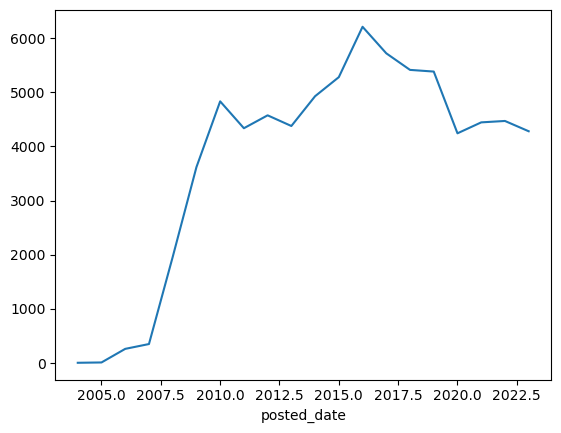

In [50]:
df.groupby(df["posted_date"].dt.year)["opportunity_id"].count().plot()

# Visualise

## Colours

['#6F4070', '#94346E', '#CC503E', '#E17C05', '#EDAD08', '#73AF48', '#0F8554', '#38A6A5', '#1D6996', '#5F4690']


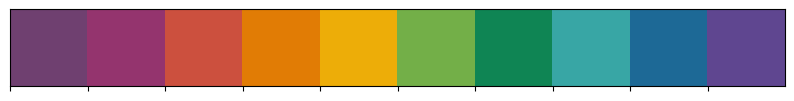

In [116]:
from palettable.cartocolors.qualitative import Prism_10_r


print(Prism_10_r.hex_colors)
sns.palplot(Prism_10_r.hex_colors)

In [376]:
top15_colors = {
    
    'Other': "#BCBCBC",

    'Department of Commerce': '#6F4070',

    'Administration for Children and Families': "#CC503E", 
    'Department of Education': '#db6535', 

    'Centers for Disease Control and Prevention' : '#efbf0f', 
    'Health Resources and Services Administration': '#e1bf12',
    'National Institutes of Health' :'#d3be17',

    'Environmental Protection Agency':'#73AF48',
    'Fish and Wildlife Service': '#60aa54',
    'Geological Survey': '#50a45e',
    'National Park Service' : '#419d67',
    'Bureau of Land Management' : '#36966e',

    'NASA Headquarters': "#38A6A5",
    'National Science Foundation':  '#1cb7c7',  

    'Department of Homeland Security - FEMA': "#00799f",
    'Dept. of the Army -- USAMRAA': '#1D6996', 

    }

## Number of grant programmes by agency over time

### Stacked bar

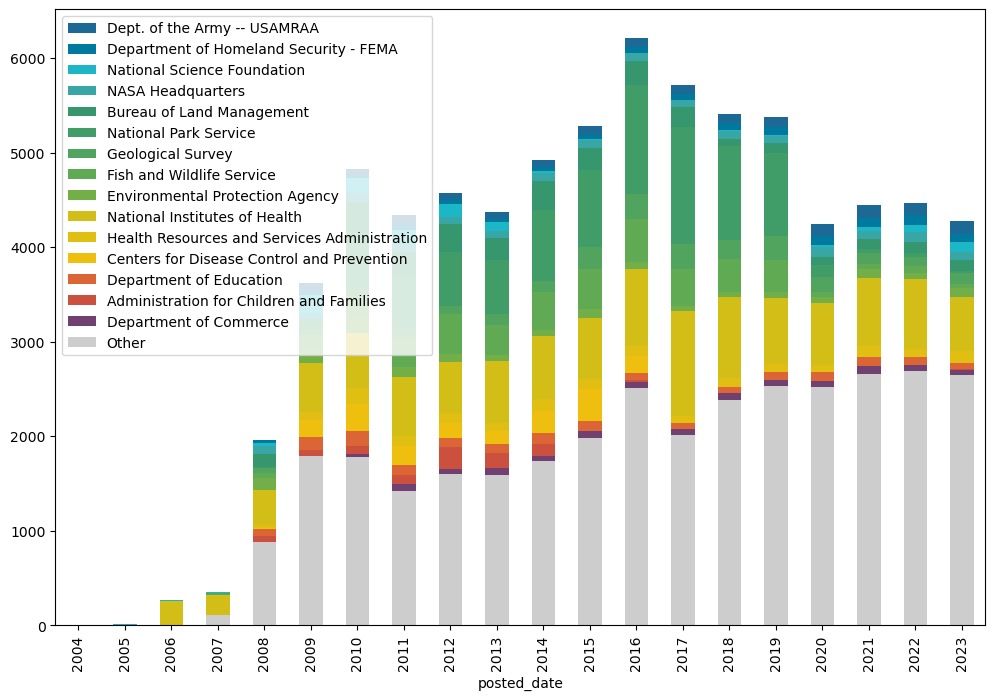

In [162]:
pivot = df.groupby([ df["posted_date"].dt.year,  "agency_top15"])["opportunity_id"].count()
pivot = pivot.unstack()

pivot = pivot[top15_colors.keys()]

fig, ax = plt.subplots(figsize=(12,8))
pivot.plot.bar(stacked=True, ax=ax, color=list(top15_colors.values()))

# Reverse the order of labels, so they match the data
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
#pivot

### Streamgraph

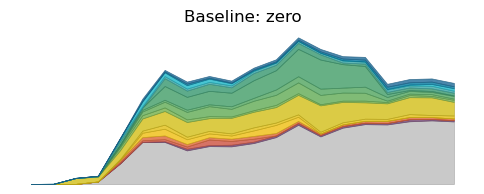

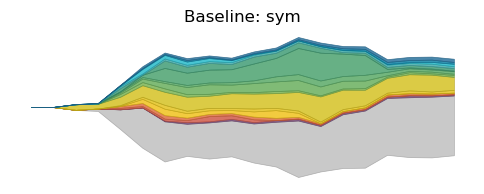

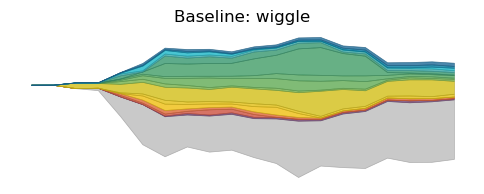

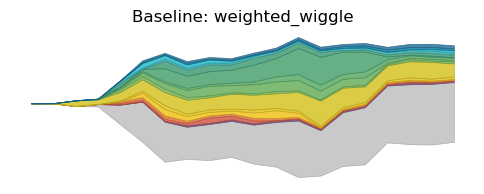

In [303]:
pivot = df.groupby([ df["posted_date"].dt.year,  "agency_top15"])["opportunity_id"].count().unstack()
pivot = pivot[top15_colors.keys()].fillna(0).transpose()

for bl in ["zero", "sym", "wiggle", "weighted_wiggle"]:
    plt.figure(figsize=(6, 2))
    colors = list(top15_colors.values())
    f = plt.stackplot(pivot.columns, pivot, colors=colors, baseline=bl, alpha=0.8, linewidth=0.5)
    [a.set_edgecolor(sns.dark_palette(colors[i])[-2]) for i,a in enumerate(f)] # Edges to be slighter darker
    
    plt.title("Baseline: {}".format(bl))
    plt.axis('off')
    plt.show()

In [304]:
from scipy import interpolate
import numpy as np

def streamgraph(dataframe, **kwargs):
    """ Wrapper around stackplot to make a streamgraph """
    X = dataframe.columns
    #Xs = np.linspace(dataframe.columns[0], dataframe.columns[-1], num=1024)
    Xs = np.linspace(dataframe.columns[0], dataframe.columns[-1], num=500)
    Ys = [interpolate.PchipInterpolator(X, y)(Xs) for y in dataframe.values]
    return plt.stackplot(Xs, Ys, labels=dataframe.index, **kwargs)

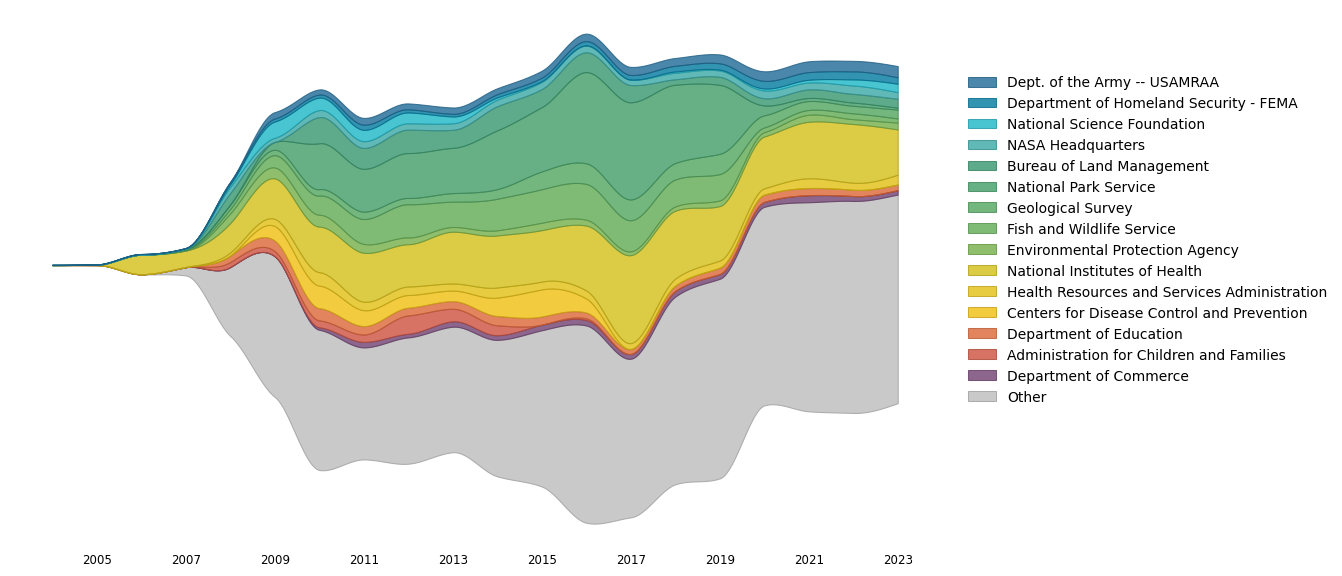

In [382]:
# prepare data for plotting
pivot = df.groupby([ df["posted_date"].dt.year,  "agency_top15"])["opportunity_id"].count().unstack()
pivot = pivot[top15_colors.keys()].fillna(0).transpose()

# setup plot
fig, ax = plt.subplots(figsize=(12,7))

# plot streamgraph
colors = list(top15_colors.values())
f = streamgraph(pivot, colors=colors, baseline="weighted_wiggle", alpha=0.8, linewidth=0.75)
[a.set_edgecolor(sns.dark_palette(colors[i])[-2]) for i,a in enumerate(f)]

# axis formatting
for pos in ["top", "left", "right", "bottom"]:
    ax.spines[pos].set_visible(False)
ax.yaxis.set_visible(False)

ax.tick_params(axis='x', length = 0, color = "#444444", labelsize=8.5)
ax.set_xticks(np.arange(2005, 2024, 2))

# Reverse the order of labels, so they match the data
handles, labels = ax.get_legend_handles_labels()
labels_new = list(top15_colors.keys())[::-1]
colors_legend = colors[::-1]
ax.legend(handles[::-1], labels[::-1], frameon=False, loc='upper right',bbox_to_anchor=(1.43,0.9))

#L = ax.legend(ncol=2, frameon=False, loc='upper right',bbox_to_anchor=(1.1,1.08))
#plt.setp(L.texts, fontproperties=font_m, fontsize=13)

# annotations


plt.show()

In [ ]:
list(top15_colors.keys())

In [ ]:
markers =  Line2D([0], [0], markerfacecolor=colours["museum"], label="Museum", marker='o', color=bg_color ,markersize=9, alpha=1)

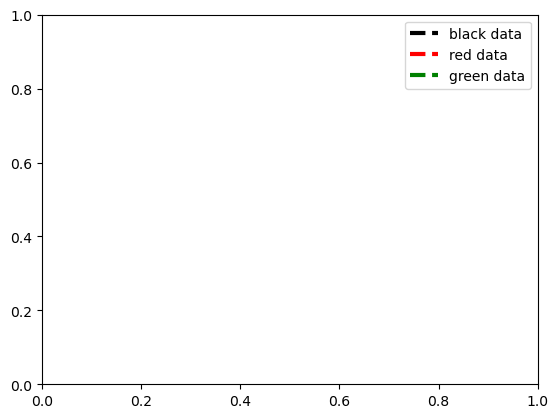

In [370]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

colors = ['black', 'red', 'green']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
labels = ['black data', 'red data', 'green data']
plt.legend(lines, labels)
plt.show()

In [360]:
labels

['Other',
 'Department of Commerce',
 'Administration for Children and Families',
 'Department of Education',
 'Centers for Disease Control and Prevention',
 'Health Resources and Services Administration',
 'National Institutes of Health',
 'Environmental Protection Agency',
 'Fish and Wildlife Service',
 'Geological Survey',
 'National Park Service',
 'Bureau of Land Management',
 'NASA Headquarters',
 'National Science Foundation',
 'Department of Homeland Security - FEMA',
 'Dept. of the Army -- USAMRAA']

In [361]:
handles

### More stackplots

<Axes: xlabel='posted_date'>

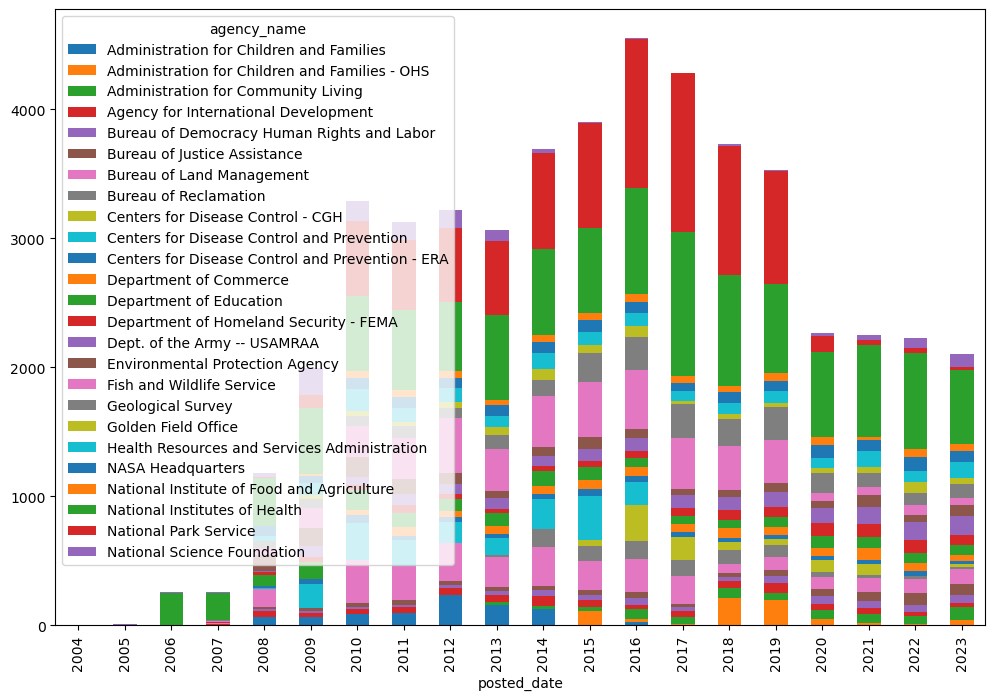

In [334]:
_filter = top.head(25)["agency_name"].to_list()
pivot = df[df["agency_name"].isin(_filter)].groupby([df["posted_date"].dt.year, "agency_name"])["opportunity_id"].count().unstack()
pivot

fig, ax = plt.subplots(figsize=(12,8))
pivot.plot.bar(stacked=True, ax=ax)
#.plot()

In [329]:
top = df["agency_name"].value_counts().to_frame().reset_index()
top.head(15)

,agency_name,count
0,National Institutes of Health,11239
1,National Park Service,8426
2,Fish and Wildlife Service,4122
3,Bureau of Land Management,2868
4,Geological Survey,2311
5,Centers for Disease Control and Prevention,1727
6,Health Resources and Services Administration,1609
7,Department of Education,1513
8,Dept. of the Army -- USAMRAA,1507
9,Environmental Protection Agency,1371


## Bumpchart

Code from Kaggle: [Olympics - Streams and bumps charts in python](https://www.kaggle.com/code/markalec/olympics-streams-and-bumps-charts-in-python)

In [284]:
from collections import defaultdict

def add_widths(x, y, width=0.1):
    """ Adds flat parts to widths """
    new_x = []
    new_y = []
    for i,j in zip(x,y):
        new_x += [i-width, i, i+width]
        new_y += [j, j, j]
    return new_x, new_y

def bumpsplot(dataframe, color_dict=defaultdict(lambda: "k"), 
                         linewidth_dict=defaultdict(lambda: 1),
                         labels=[]):
    r = dataframe.rank(method="first")
    r = (r - r.max() + r.max().max()).fillna(0) # Sets NAs to 0 in rank
    for i in r.index:
        x = np.arange(r.shape[1])
        y = r.loc[i].values
        color = color_dict[i]
        lw = linewidth_dict[i]
        x, y = add_widths(x, y, width=0.1)
        xs = np.linspace(0, x[-1], num=1024)
        plt.plot(xs, interpolate.PchipInterpolator(x, y)(xs), color=color, linewidth=lw, alpha=0.5)
        if i in labels:
            plt.text(x[0] - 0.1, y[0], s=i, horizontalalignment="right", verticalalignment="center", color=color)
            plt.text(x[-1] + 0.1, y[-1], s=i, horizontalalignment="left", verticalalignment="center", color=color)
    plt.xticks(np.arange(r.shape[1]), dataframe.columns)



In [297]:
_filter = df["posted_date"].dt.year>=2008
_agency_filter = df["agency_name"].isin(top.head(25)["agency_name"].to_list())

pivot = df[_filter & _agency_filter].groupby([ df["posted_date"].dt.year,  "agency_name"])["opportunity_id"].count().unstack()

pivot = pivot.fillna(0).transpose()

winter_colors = defaultdict(lambda: "grey")
lw = defaultdict(lambda: 1)

top_agency = pivot.iloc[:, 0].dropna().sort_values().index
for i,c in enumerate(top_agency):
    winter_colors[c] = sns.color_palette("husl", n_colors=len(top_agency))[i]
    lw[c] = 4

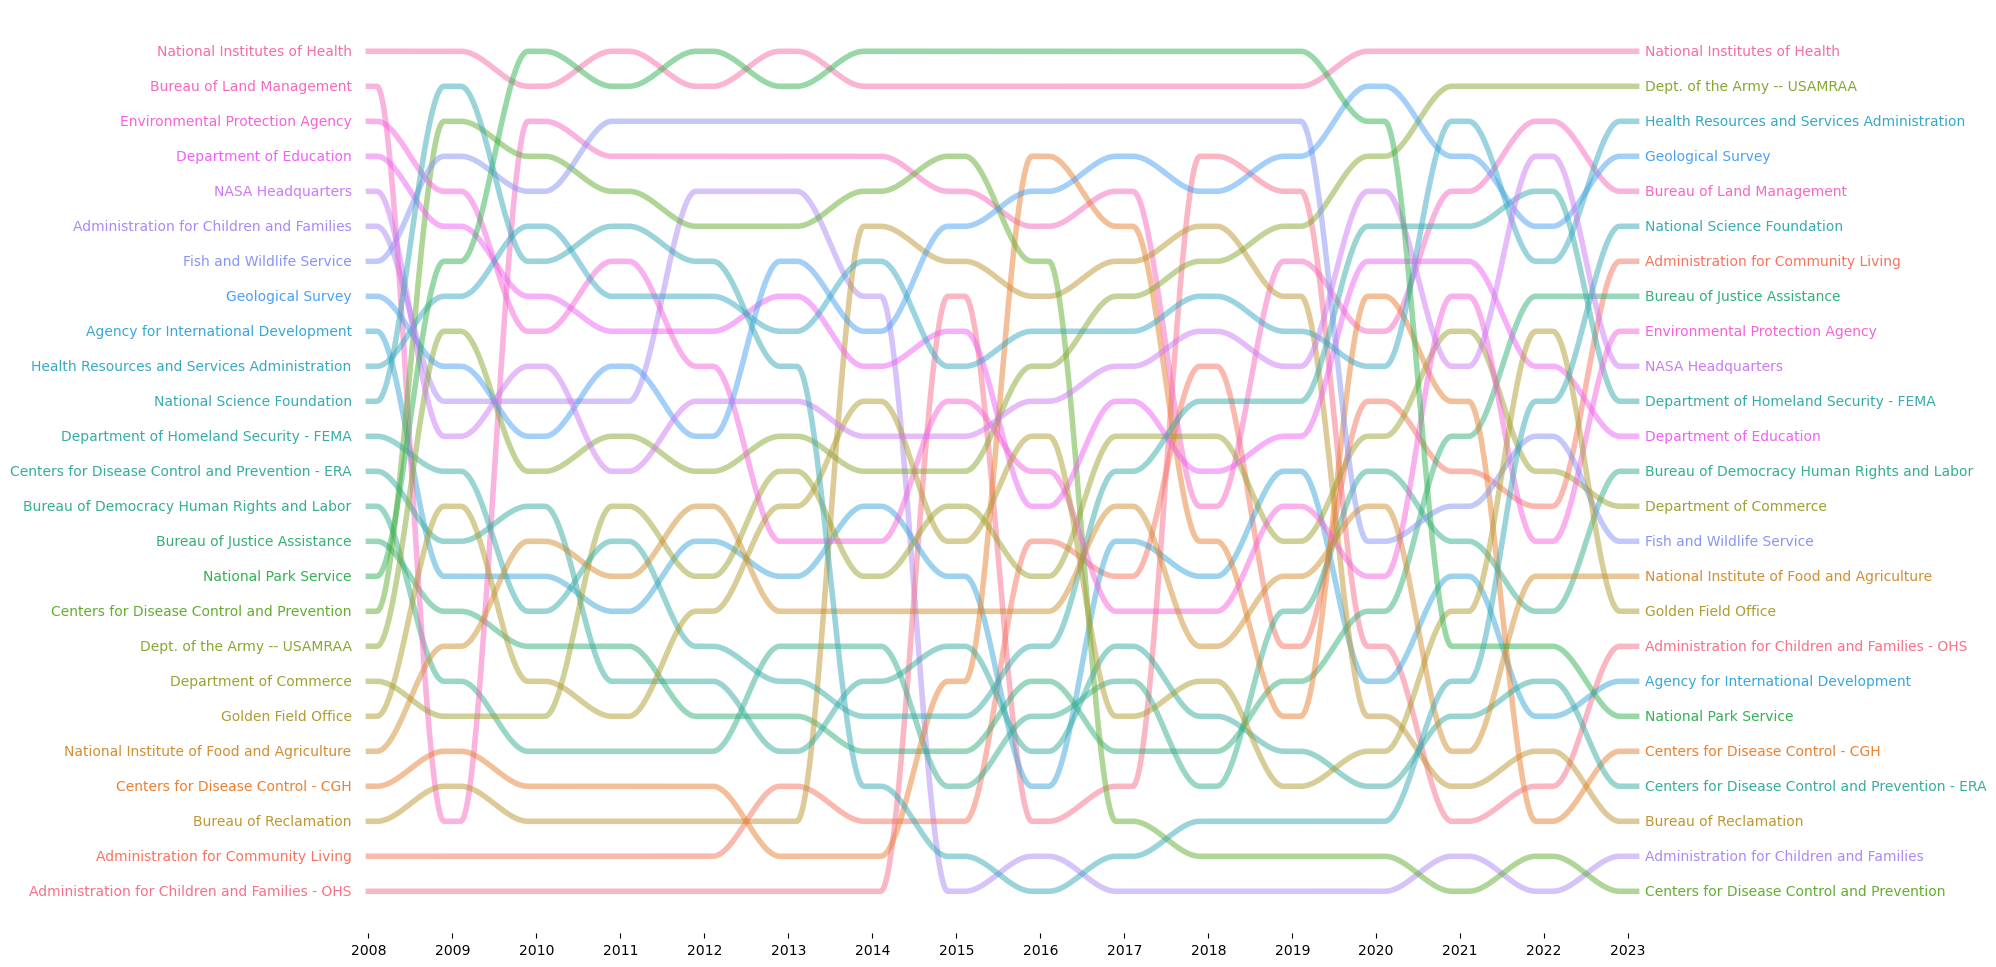

In [300]:
fig, ax = plt.subplots(figsize=(18,12))
bumpsplot(pivot, color_dict=winter_colors, linewidth_dict=lw, labels=top_agency)
ax.get_yaxis().set_visible(False)

for pos in ["top", "left", "right", "bottom"]:
    ax.spines[pos].set_visible(False)